<a href="https://colab.research.google.com/github/yohanesnuwara/open-geoscience-repository/blob/master/open_dlis_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q dlisio

     |████████████████████████████████| 440kB 9.1MB/s 


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dlisio

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [58]:
!git clone https://github.com/yohanesnuwara/geostatistics

Cloning into 'geostatistics'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 230 (delta 35), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (230/230), 58.89 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [59]:
# Unzip file
!pip install unrar
!unrar x "/content/geostatistics/data/volve-realtime/well_15_9_F-14/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/geostatistics/data/volve-realtime/well_15_9_F-14/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.rar


Would you like to replace the existing file WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS
36247348 bytes, modified on 2021-02-08 04:10
with a new one
36247348 bytes, modified on 2021-02-07 06:35

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS                    16% 32% 49% 65% 81% 98% 99%  OK 
All OK


## My tutorial (DLISIO doc + Erlend Viggen's notebook)

### Open file

Open and display the Physical File

In [61]:
filename = "/content/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS"

f = dlisio.load(filename)

f.describe()

-------------
Physical File
-------------
Number of Logical Files : 1

Description : logicalfile(Run_5)
Frames      : 2
Channels    : 300


Open and display the Logical Files

In [106]:
filename = "/content/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS"

f, *f_tail = dlisio.load(filename)

f.describe()

------------
Logical File
------------
Description : logicalfile(Run_5)
Frames      : 2
Channels    : 300

Known objects
--
FILE-HEADER             : 1
ORIGIN                  : 1
EQUIPMENT               : 8
TOOL                    : 1
PARAMETER               : 352
CALIBRATION-MEASUREMENT : 44
CALIBRATION-COEFFICIENT : 170
CALIBRATION             : 344
CHANNEL                 : 300
FRAME                   : 2


### Print header information

Print header (usually this contains info of field name, well name, operator, tool name, and date created)

In [107]:
origin, *origin_tail = f.origins

if len(origin_tail): logging.warning('f contains multiple origins')

origin.describe()

------
Origin
------
name   : DLIS_DEFINING_ORIGIN
origin : 41
copy   : 0

Logical file ID          : Run_5
File set name and number : STATOILHYDRO/15_9_F_14 / 41
File number and type     : 17 / LWD

Field                   : Volve
Well (id/name)          :  / 15/9-F-14
Produced by (code/name) : 440 / Schlumberger
Produced for            : StatoilHydro
Order number            : 07SCA0093
Run number              : 5
Descent number          : -1
Created                 : 2008-06-24 10:20:00

Created by              : DlisBrowser, (version: ID13_0C_03)
Other programs/services : ECO6: EcoScope Integrated Logging-While-Drilling Tool
                          - 6.75 inch


More details on well coordinate, bit size, casing size, and start log datetime can be extracted. 

In [65]:
def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One 
    object pr. row
    
    Parameters
    ----------
    
    objs : list()
        list of metadata objects
        
    **kwargs
        Keyword arguments 
        Use kwargs to tell summarize() which fields (attributes) of the 
        objects you want to include in the DataFrame. The parameter name 
        must match an attribute on the object in 'objs', while the value 
        of the parameters is used as a column name. Any kwargs are excepted, 
        but if the object does not have the requested attribute, 'KeyError' 
        is used as the value.
        
    Returns
    -------
    
    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'
    
            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

In [108]:
parameter_table = summarize(f.parameters, name='Name', long_name='Long name', values='Value(s)')

# Hide parameters containing names; see the privacy note in the Introduction. Comment out these lines to show them.
mask = ~parameter_table['Name'].isin(['R8', 'RR1', 'WITN', 'ENGI'])
parameter_table = parameter_table[mask]

desc_parameters = ['CN', 'WN', 'FN',                                     # Well ID
                   'NATI', 'CONT', 'FL', 'FL1', 'FL2', 'LONG', 'LATI',   # Well location
                   'DLAB', 'TLAB',                                       # Time and date of well logging
                   'CSIZ', 'THNO', 'BS']                                 # Casing and well parameters

# Create a table out of the parameters in desc_parameters
desc_table = parameter_table.loc[parameter_table['Name'].isin(desc_parameters)].copy()

# Sort the table in the same order as desc_parameters
categorical_sorter = pd.Categorical(desc_parameters, desc_parameters, ordered=True)
desc_table['Name'] = desc_table['Name'].astype(categorical_sorter.dtype)
desc_table.sort_values(by='Name', inplace=True)

display(desc_table)

/usr/local/lib/python3.6/dist-packages/dlisio/plumbing/parameter.py:130: UnicodeWarning: unable to decode string b"01\xb0 53' 15.079'' E                                                                                                             "
  values = self.attic['VALUES'].value
/usr/local/lib/python3.6/dist-packages/dlisio/plumbing/parameter.py:130: UnicodeWarning: unable to decode string b"58\xb0 26' 29.769'' N                                                                                                             "
  values = self.attic['VALUES'].value


,Name,Long name,Value(s)
348,CN,Company Name,[StatoilHydro ...
346,WN,Well Name,[15/9-F-14 ...
345,FN,Field Name,[Volve ...
330,CONT,Continent,[ ...
342,FL,Field Location,[North Sea ...
341,FL1,Field Location Line 1,[ ...
340,FL2,Field Location Line 2,[ ...
334,LONG,Longitude,"[b""01\xb0 53' 15.079'' E ..."
335,LATI,Latitude,"[b""58\xb0 26' 29.769'' N ..."
327,DLAB,Begin Log Date,[10-Jun-08 ...


### Print all log data (mnemonics)

Print all log data, its description, and units.

In [109]:
channel_table = summarize(f.channels, name='Name', long_name='Long name', units='Units',
                                      dimension='Dimension', frame='Frame')
channel_table.sort_values('Name')

,Name,Long name,Units,Dimension,Frame
289,1TIM,0.1-ft Frame Time,ms,[1],Frame(12B)
262,6TIM,6-in. Frame Time,ms,[1],Frame(60B)
219,A112,ARC Amplitude R1 from T1 at 2 MHz,mV,[1],Frame(60B)
239,A114,ARC Amplitude R1 from T1 at 400 KHz,mV,[1],Frame(60B)
221,A122,ARC Amplitude R1 from T2 at 2 MHz,mV,[1],Frame(60B)
241,A124,ARC Amplitude R1 from T2 at 400 KHz,mV,[1],Frame(60B)
223,A132,ARC Amplitude R1 from T3 at 2 MHz,mV,[1],Frame(60B)
243,A134,ARC Amplitude R1 from T3 at 400 KHz,mV,[1],Frame(60B)
225,A142,ARC Amplitude R1 from T4 at 2 MHz,mV,[1],Frame(60B)
245,A144,ARC Amplitude R1 from T4 at 400 KHz,mV,[1],Frame(60B)


### Extract data

Extract the data as arrays. First we want to extract the depth.

> Note that only passing `f.object('CHANNEL', 'TDEP')` raises error because there are more than 1 column in this data. So, specify the `origin` and `copynr`. 

In [84]:
obj = f.object('CHANNEL', 'TDEP', origin=41, copynr=0)

obj.describe()

-------
Channel
-------
name   : TDEP
origin : 41
copy   : 0

Description : 6-Inch Frame Depth

Physical unit of sample   : 0.1 in
Sample dimensions         : 1
Maximum sample dimensions : 1
Property indicators       : 440-CUSTOMER


In [85]:
TDEP = obj.curves()
print(TDEP)

[1093680. 1093740. 1093800. ... 1476240. 1476300. 1476360.]


Mind the units of TDEP here is 0.1 in. So, we must convert it to M or FT. 

1 in = 0.0254 M, so: 0.1 in = 2.54E-3 M

In [87]:
TDEP = TDEP * 2.54E-3
print(TDEP)

[2777.9473 2778.0996 2778.252  ... 3749.6497 3749.802  3749.9543]


Next I want to extract RLSC (long spacing bulk density). This log has 16 dimensions (16 sectors of azimuths). 

In [110]:
obj = f.object('CHANNEL', 'RLSC')

obj.describe()

-------
Channel
-------
name   : RLSC
origin : 41
copy   : 0

Description : Long Spacing Bulk Density, 16-Sector

Physical unit of sample   : g/cm3
Sample dimensions         : 16
Maximum sample dimensions : 16
Property indicators       : 440-CUSTOMER
Source                    : Tool(ECO6)


In [73]:
obj.curves().shape

(6379, 16)

Extract the first azimuth of RLSC; RLSC[0]

In [114]:
RLSC_0 = obj.curves()[:,0]
print(RLSC_0)

[   3.1655688    3.0862267    3.0813913 ... -999.25      -999.25
 -999.25     ]


Make dataframe.

In [88]:
df = pd.DataFrame({"TDEP": TDEP, "RLSC[0]": RLSC_0})

df.head()

,TDEP,RLSC[0]
0,2777.947266,3.165569
1,2778.099609,3.086227
2,2778.251953,3.081391
3,2778.404297,3.086951
4,2778.556885,3.188139


### Visualize log

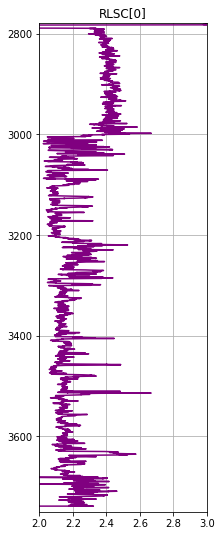

In [102]:
plt.figure(figsize=(3,9))

plt.plot(df["RLSC[0]"], df["TDEP"], color="purple")
plt.ylim(max(df["TDEP"]), min(df["TDEP"]))
plt.xlim(2,3)
plt.title("RLSC[0]")

plt.grid()
plt.show()

## DLISIO documentation

In [30]:
filename = "/content/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS"

f = dlisio.load(filename)

f.describe()

-------------
Physical File
-------------
Number of Logical Files : 1

Description : logicalfile(Run_5)
Frames      : 2
Channels    : 300


In [31]:
filename = "/content/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS"

f, *f_tail = dlisio.load(filename)

f.describe()

------------
Logical File
------------
Description : logicalfile(Run_5)
Frames      : 2
Channels    : 300

Known objects
--
FILE-HEADER             : 1
ORIGIN                  : 1
EQUIPMENT               : 8
TOOL                    : 1
PARAMETER               : 352
CALIBRATION-MEASUREMENT : 44
CALIBRATION-COEFFICIENT : 170
CALIBRATION             : 344
CHANNEL                 : 300
FRAME                   : 2


In [56]:
obj = f.object('CHANNEL', 'TDEP', origin=41, copynr=1)

obj.describe()

-------
Channel
-------
name   : TDEP
origin : 41
copy   : 1

Description : 0.1-ft Frame Depth

Physical unit of sample   : 0.1 in
Sample dimensions         : 1
Maximum sample dimensions : 1
Property indicators       : 440-CUSTOMER


In [53]:
obj.curves()

array([1093680., 1093692., 1093704., ..., 1476336., 1476348., 1476360.],
      dtype=float32)

## Tutorial from Erlend Viggen

In [5]:
filename = "/content/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1.DLIS"

f, *f_tail = dlisio.load(filename)

if len(f_tail): logging.warning('There are more logical files in tail')

In [6]:
origin, *origin_tail = f.origins

if len(origin_tail): logging.warning('f contains multiple origins')

In [7]:
f.describe()

------------
Logical File
------------
Description : logicalfile(Run_5)
Frames      : 2
Channels    : 300

Known objects
--
FILE-HEADER             : 1
ORIGIN                  : 1
EQUIPMENT               : 8
TOOL                    : 1
PARAMETER               : 352
CALIBRATION-MEASUREMENT : 44
CALIBRATION-COEFFICIENT : 170
CALIBRATION             : 344
CHANNEL                 : 300
FRAME                   : 2


In [8]:
origin.describe()

------
Origin
------
name   : DLIS_DEFINING_ORIGIN
origin : 41
copy   : 0

Logical file ID          : Run_5
File set name and number : STATOILHYDRO/15_9_F_14 / 41
File number and type     : 17 / LWD

Field                   : Volve
Well (id/name)          :  / 15/9-F-14
Produced by (code/name) : 440 / Schlumberger
Produced for            : StatoilHydro
Order number            : 07SCA0093
Run number              : 5
Descent number          : -1
Created                 : 2008-06-24 10:20:00

Created by              : DlisBrowser, (version: ID13_0C_03)
Other programs/services : ECO6: EcoScope Integrated Logging-While-Drilling Tool
                          - 6.75 inch


In [10]:
def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One 
    object pr. row
    
    Parameters
    ----------
    
    objs : list()
        list of metadata objects
        
    **kwargs
        Keyword arguments 
        Use kwargs to tell summarize() which fields (attributes) of the 
        objects you want to include in the DataFrame. The parameter name 
        must match an attribute on the object in 'objs', while the value 
        of the parameters is used as a column name. Any kwargs are excepted, 
        but if the object does not have the requested attribute, 'KeyError' 
        is used as the value.
        
    Returns
    -------
    
    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'
    
            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

In [13]:
parameter_table = summarize(f.parameters, name='Name', long_name='Long name', values='Value(s)')

# Hide parameters containing names; see the privacy note in the Introduction. Comment out these lines to show them.
mask = ~parameter_table['Name'].isin(['R8', 'RR1', 'WITN', 'ENGI'])
parameter_table = parameter_table[mask]

parameter_table.sort_values('Name')

/usr/local/lib/python3.6/dist-packages/dlisio/plumbing/parameter.py:130: UnicodeWarning: unable to decode string b"01\xb0 53' 15.079'' E                                                                                                             "
  values = self.attic['VALUES'].value
/usr/local/lib/python3.6/dist-packages/dlisio/plumbing/parameter.py:130: UnicodeWarning: unable to decode string b"58\xb0 26' 29.769'' N                                                                                                             "
  values = self.attic['VALUES'].value


,Name,Long name,Value(s)
237,A12A,ARC Air Cal Attenuation From T1 at 2 MHz,[8.141980171203613]
227,A14A,ARC Air Cal Attenuation From T1 at 400 KHz,[8.187259674072266]
236,A22A,ARC Air Cal Attenuation From T2 at 2 MHz,[6.26515007019043]
226,A24A,ARC Air Cal Attenuation From T2 at 400 KHz,[6.233280181884766]
235,A32A,ARC Air Cal Attenuation From T3 at 2 MHz,[4.758490085601807]
...,...,...,...
169,WPSL,Salinity of the Water Phase Emulsified within ...,[64.68000030517578]
186,WRK,Way to Report Potassium Concentration,[POTASSIUM_BY_WEIGHT_%]
162,WSDI,Window Size of Dynamic Normalization Image,[15.24000072479248]
249,XPDM_RM,Cross plot density prosity multiplier,[0.675000011920929]


In [14]:
desc_parameters = ['CN', 'WN', 'FN',                                     # Well ID
                   'NATI', 'CONT', 'FL', 'FL1', 'FL2', 'LONG', 'LATI',   # Well location
                   'DLAB', 'TLAB',                                       # Time and date of well logging
                   'CSIZ', 'THNO', 'BS']                                 # Casing and well parameters

# Create a table out of the parameters in desc_parameters
desc_table = parameter_table.loc[parameter_table['Name'].isin(desc_parameters)].copy()

# Sort the table in the same order as desc_parameters
categorical_sorter = pd.Categorical(desc_parameters, desc_parameters, ordered=True)
desc_table['Name'] = desc_table['Name'].astype(categorical_sorter.dtype)
desc_table.sort_values(by='Name', inplace=True)

display(desc_table)

,Name,Long name,Value(s)
348,CN,Company Name,[StatoilHydro ...
346,WN,Well Name,[15/9-F-14 ...
345,FN,Field Name,[Volve ...
330,CONT,Continent,[ ...
342,FL,Field Location,[North Sea ...
341,FL1,Field Location Line 1,[ ...
340,FL2,Field Location Line 2,[ ...
334,LONG,Longitude,"[b""01\xb0 53' 15.079'' E ..."
335,LATI,Latitude,"[b""58\xb0 26' 29.769'' N ..."
327,DLAB,Begin Log Date,[10-Jun-08 ...


In [17]:
remarks = f.match('^R[0-9]{1,2}', type='parameter')
remarks = sorted(remarks, key=lambda x: int(x.name[1:]) )

for remark in remarks:
    #if not remark.values: continue    # Uncomment to skip empty remarks
    if remark.name == 'R8': continue   # Hide a remark containing a name; comment out the line to show the remark
    print(f'{remark.name}: {" ".join(remark.values)}')

/usr/local/lib/python3.6/dist-packages/dlisio/file.py:321: FutureWarning: match is deprecated and will be removed in a future version, use find('parameter', '^R[0-9]{1,2}') instead
  warnings.warn(msg, FutureWarning)


In [18]:
for frame in f.frames:
    index_channel = next(ch for ch in frame.channels if ch.name == frame.index)
    print(f'Frame {frame.name}:')
    print(f'Description      : {frame.description}')
    print(f'Indexed by       : {frame.index_type}')
    print(f'Interval         : [{frame.index_min}, {frame.index_max}] {index_channel.units}')
    print(f'Direction        : {frame.direction}')
    print(f'Constant spacing : {frame.spacing} {index_channel.units}')
    print(f'Index channel    : {index_channel}')
    print(f'No. of channels  : {len(frame.channels)}')
    print()

Frame 60B:
Description      : 60.00 0.1 in frame data
Indexed by       : BOREHOLE-DEPTH
Interval         : [1093680.0, 1476360.0] 0.1 in
Direction        : INCREASING
Constant spacing : 60.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 281

Frame 12B:
Description      : 12.00 0.1 in frame data
Indexed by       : BOREHOLE-DEPTH
Interval         : [1093680.0, 1476360.0] 0.1 in
Direction        : INCREASING
Constant spacing : 12.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 19



In [19]:
channel_table = summarize(f.channels, name='Name', long_name='Long name', units='Units',
                                      dimension='Dimension', frame='Frame')
channel_table.sort_values('Name')

,Name,Long name,Units,Dimension,Frame
289,1TIM,0.1-ft Frame Time,ms,[1],Frame(12B)
262,6TIM,6-in. Frame Time,ms,[1],Frame(60B)
219,A112,ARC Amplitude R1 from T1 at 2 MHz,mV,[1],Frame(60B)
239,A114,ARC Amplitude R1 from T1 at 400 KHz,mV,[1],Frame(60B)
221,A122,ARC Amplitude R1 from T2 at 2 MHz,mV,[1],Frame(60B)
...,...,...,...,...,...
158,WCOA_WALK2,Dry Weight Fraction Coal (SpectroLith WALK2 Mo...,%,[1],Frame(60B)
159,WEVA_WALK2,Dry Weight Fraction Salt (SpectroLith WALK2 Mo...,%,[1],Frame(60B)
156,WPYR_WALK2,Dry Weight Fraction Pyrite (SpectroLith WALK2 ...,%,[1],Frame(60B)
155,WQFM_WALK2,Dry Weight Fraction Quartz+Feldspar+Mica (QFM)...,%,[1],Frame(60B)


In [23]:
def index_of(frame):
    """Return the index channel of the frame"""
    return next(ch for ch in frame.channels if ch.name == frame.index)

def get_channel(frame, name):
    """Get a channel with a given name from a given frame; fail if the frame does not have exactly one such channel"""
    [channel] = [x for x in frame.channels if x.name == name]
    return channel

# Get 20B and its index channel
frame60B = f.object('frame', '20B')
# index60B = index_of(frame60B)

# # Get the metadata related to WF1 and WF2
# wf1 = get_channel(frame60B, 'WSID_WALK2')

ValueError: ignored